loss is [5.7310934 0.7982509 6.5293446]
loss is [2.6826795e-02 9.5367432e-05 2.6922163e-02]
loss is [8.9041349e-03 5.7487564e-06 8.9098839e-03]
loss is [5.0886618e-03 7.5501589e-07 5.0894166e-03]
loss is [2.4306274e-03 5.5582228e-07 2.4311831e-03]
loss is [3.9638494e-04 1.6418086e-07 3.9654912e-04]
loss is [4.9867725e-04 5.3086842e-05 5.5176410e-04]
loss is [7.8678015e-05 3.1258338e-09 7.8681143e-05]
loss is [5.5083801e-05 5.9598301e-07 5.5679786e-05]
loss is [3.0518022e-05 1.9244908e-09 3.0519946e-05]
0.9623933434486389
loss is [3.6904998  0.33576363 4.026263  ]
loss is [2.5998836e+00 5.3208089e-04 2.6004157e+00]
loss is [3.2112943e-03 3.1066018e-05 3.2423604e-03]
loss is [5.9011840e-04 4.5356572e-07 5.9057196e-04]
loss is [3.6695269e-03 7.4691685e-05 3.7442185e-03]
loss is [2.5654276e-04 1.3656631e-07 2.5667931e-04]
loss is [1.7976973e-04 1.5135174e-07 1.7992109e-04]
loss is [1.6817021e-04 1.1522525e-07 1.6828543e-04]
loss is [1.1756571e-04 3.4605709e-08 1.1760031e-04]
loss is [1.515

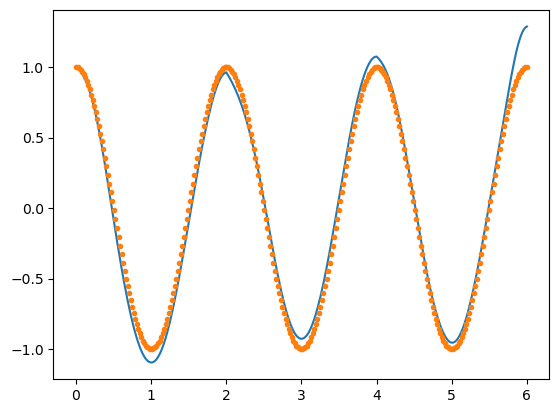

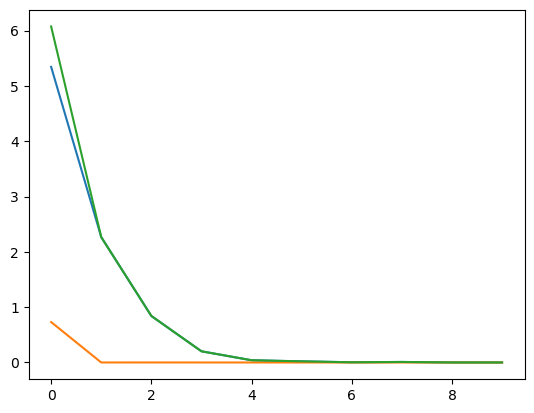

In [2]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

solver = CloudPointSolver(
    model = [1, 100, 100, 100, 1],
    optimizer = "adam"
    )

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx + torch.pi * torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num

bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num

T_iter = 3
epoch_per_iter = 1000

x_all = []
y_all = []

for T_id in range(T_iter):
    ## define a pde
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 +0.2

    pde_input = D1Field([t_span_start, t_span_end]).get_field_rand(pde_epoch_size)
    pde_output = np.zeros([pde_epoch_size,1])

    ## define a bc
    bc_input = np.array([[t_span_start]])
    bc_output = np.array(1.).reshape([bc_epoch_size ,1])
    if T_id != 0:
        bc_output[0] = last_flame_data
    
    solver = CloudPointSolver(
        model = [1, 100, 100, 100, 1],
        optimizer = "adam",
    )

    for epoch_local_id in range(epoch_per_iter):
        epoch_id = T_id * epoch_per_iter + epoch_local_id
        solver.train_step(
            cloud_point_list = [[pde_input, pde_output],[bc_input, bc_output]],
            loss_list = [pde_loss,data_loss],
            batchsize= [pde_batch_size,bc_batch_size],
            loss_weight_list=[1,1]
        )
        if epoch_local_id % 100 == 0:
            solver.test_step(
                cloud_point_list = [[pde_input, pde_output],[bc_input, bc_output]],
                loss_list = [pde_loss,data_loss],
                batchsize= [pde_batch_size,bc_batch_size],
                loss_weight_list=[1,1],
                print_flag=True)

    x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
    y_cpu = solver.model_eval(x_cpu)
    
    last_flame_data = solver.model_eval([[t_span_start + 2]]).item()
    print(last_flame_data)

    if T_id == 0:
        x_all = x_cpu
        y_all = y_cpu
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_all = np.vstack([y_all,y_cpu])


import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_all,y_all)
y_all_real = np.cos(np.pi*np.array(x_all))
ax.plot(np.array(x_all), y_all_real,'.')
y_all_real = np.cos(np.pi*np.array(x_all))
print('total error', np.mean(np.abs(np.array(y_all_real)-np.array(y_all))) )
test_log = solver.get_logger()
test_log_np = np.array(test_log)

fig,ax = plt.subplots()
plt.plot(test_log_np[:,0])
plt.plot(test_log_np[:,1])
plt.plot(test_log_np[:,2])
print(test_log_np)
